In [3]:
from config import *
import Data.get_data_3 as _Data
import matplotlib.pyplot as plt

config = set_config(jup_notebook=True, dataset='msra10k')

config.normalize = False
train_loader, test_loader = _Data.get_data(config)

print(config.dataset)

print(len(train_loader))

loader = iter(train_loader)
img, spx, obj_label, num_obj, info = next(loader)

try:    
    print('img: ', img.shape)
    print('obj_label: ', obj_label.shape)
    print('spx: ', spx.shape)
    print('num_obj: ', num_obj)
    print('info: ', info)    
except:
    print('loader failure')

msra10k
3000
img:  torch.Size([1, 3, 3, 256, 256])
obj_label:  torch.Size([1, 3, 1, 256, 256])
spx:  torch.Size([1, 3, 1, 256, 256])
num_obj:  tensor([3], dtype=torch.int32)
info:  {'name': ['80342']}


<IPython.core.display.Javascript object>


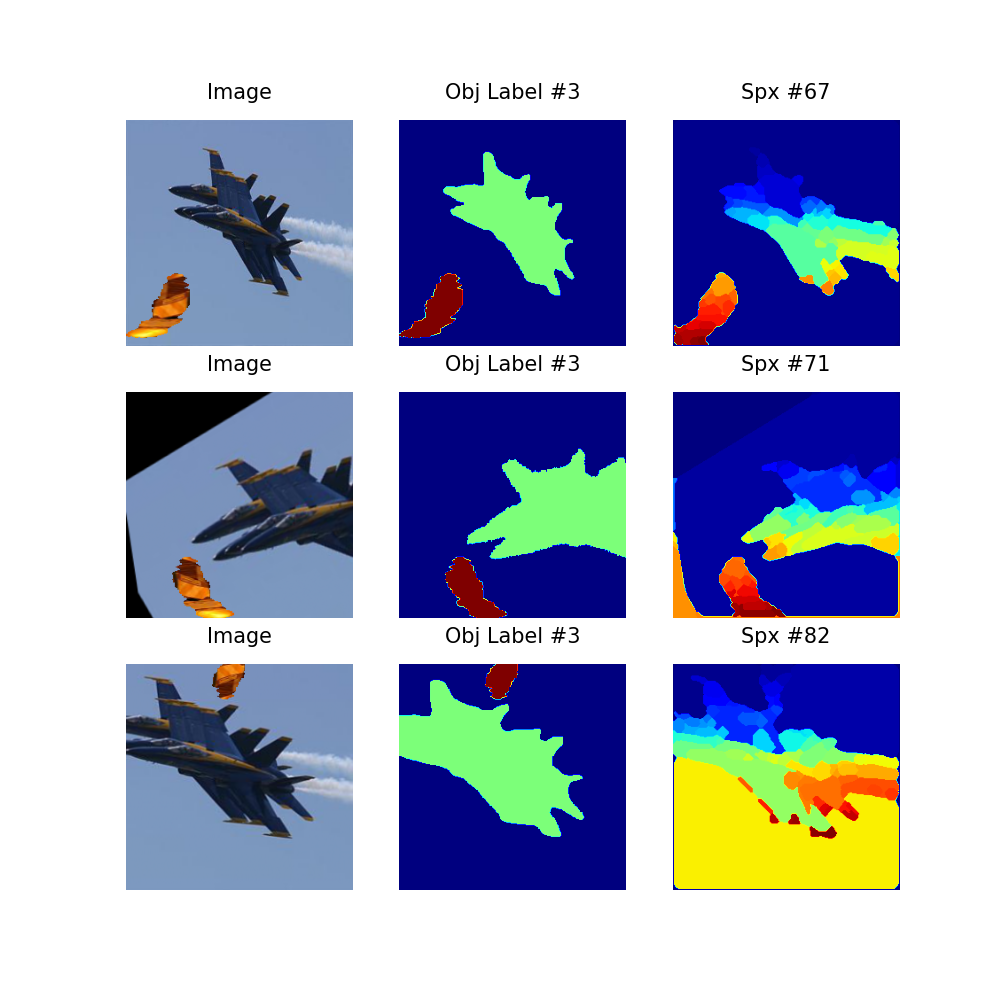

In [4]:
%matplotlib notebook
plt.rcParams['figure.dpi'] = 200    
plt.figure(num=1, figsize=(4, 4))
b = 0
for t in range(3):
    plt.subplot(3,3,3*t+1)
    plt.axis('off')
    plt.title('Image', fontsize=6)
    plt.imshow(img[b,t].permute(1,2,0), cmap='brg')
    plt.subplot(3,3,3*t+2)
    plt.axis('off')
    plt.title('Obj Label #{}'.format(obj_label[b, t, 0].max().int()), fontsize=6)
    plt.imshow(obj_label[b, t, 0], cmap='jet')
    plt.subplot(3,3,3*t+3)
    plt.axis('off')
    plt.title('Spx #{}'.format(spx[b, t, 0].max().int()), fontsize=6)
    plt.imshow(spx[b,t,0], cmap='jet')
print()

In [63]:
import torch

y = obj_label[0, 0, 0].clone()
print('y: ', y.shape)

x1 = obj_label[0, 0, 0].clone()
print('x1: ', x1.shape)

x2 = obj_label[0, 0, 0].clone()
x2[x2==3] = 1
print('x2: ', x2.shape)

x3 = obj_label[0, 0, 0].clone()
x3[x3==2] = 1
print('x3: ', x3.shape)

x4 = torch.ones_like(obj_label[0, 0, 0])
print('x4: ', x4.shape)


y:  torch.Size([256, 256])
x1:  torch.Size([256, 256])
x2:  torch.Size([256, 256])
x3:  torch.Size([256, 256])
x4:  torch.Size([256, 256])


In [64]:

from utils import get_spx_pools

def iou_metrics(obj_label, spx, pred, y_train, idx_train, idx_test):
    train_spx = torch.zeros_like(spx)
    test_spx = torch.zeros_like(spx)
    
    for n, i in enumerate(idx_train):    
        train_spx[spx==i] = y_train[n]
    
    for n, i in enumerate(idx_test):    
        test_spx[spx==i] = pred[n]
    
    iou = 0.0
    i_ = 0
    u_ = 0
    
    valid = (train_spx==0).int()
    for k in range(2, obj_label.max()+1):
        
        ground_truth = (obj_label==k).int()
        prediction = (test_spx==k).int()
        
        i_ += torch.count_nonzero(ground_truth * prediction * valid)
        u_ += torch.count_nonzero((ground_truth + prediction) * valid)
        
        print('[k={}] i: {}, u: {}'.format(k, i_, u_))
        
    if u_>0: iou = i_/u_    
    return iou    

def mask_iou(mask, label):
    mask = mask.int()
    label = label.int()
    iou = 0.0
    i_ = 0
    u_ = 0
    
    for k in range(2,label.max()+1):            
        ground_truth = (label==k).int()
        prediction = (mask==k).int()
        i_ += torch.count_nonzero(ground_truth * prediction)
        u_ += torch.count_nonzero(ground_truth + prediction)
        print('[k={}] i: {}, u: {}'.format(k, i_, u_))
    if u_>0: iou += i_/u_        
    return iou

iou_x1 = mask_iou(x1, y)
iou_x2 = mask_iou(x2, y)
iou_x3 = mask_iou(x3, y)
iou_x4 = mask_iou(x4, y)
print('-----------------------')
y_pools, new_spx = get_spx_pools(spx[:,0], y.unsqueeze(0).unsqueeze(0))
x1_pools, _ = get_spx_pools(spx[:,0], x1.unsqueeze(0).unsqueeze(0))
x2_pools, _ = get_spx_pools(spx[:,0],x2.unsqueeze(0).unsqueeze(0))
x3_pools, _ = get_spx_pools(spx[:,0],x3.unsqueeze(0).unsqueeze(0))
x4_pools, _ = get_spx_pools(spx[:,0],x4.unsqueeze(0).unsqueeze(0))

idx = torch.arange(1, y_pools[0].shape[0]+1)
miou_x1 = iou_metrics(new_spx[0,0].clone(), spx[0,0,0].clone(), x1_pools[0], [], [], idx)
miou_x2 = iou_metrics(new_spx[0,0].clone(), spx[0,0,0].clone(), x2_pools[0], [], [], idx)
miou_x3 = iou_metrics(new_spx[0,0].clone(), spx[0,0,0].clone(), x3_pools[0], [], [], idx)
miou_x4 = iou_metrics(new_spx[0,0].clone(), spx[0,0,0].clone(), x4_pools[0], [], [], idx)

print('\n\niou_x1: {}, iou_x2: {}'.format(iou_x1,iou_x2))
print('iou_x3: {}, iou_x4: {}'.format(iou_x3,iou_x4))

print('\nx1-x2: {}, x1-x3: {}, x2+x3: {}'.format(iou_x1-iou_x2, iou_x1-iou_x3, iou_x2+iou_x3))

print('\nmiou_x1: {}, miou_x2: {}'.format(miou_x1,miou_x2))
print('miou_x3: {}, miou_x4: {}'.format(miou_x3,miou_x4))

print('\nmx1-mx2: {}, mx1-mx3: {}, mx2+mx3: {}'.format(miou_x1-miou_x2, miou_x1-miou_x3, miou_x2+miou_x3))


[k=2] i: 9802, u: 9802
[k=3] i: 12207, u: 12207
[k=2] i: 9802, u: 9802
[k=3] i: 9802, u: 12207
[k=2] i: 0, u: 9802
[k=3] i: 2405, u: 12207
[k=2] i: 0, u: 9802
[k=3] i: 0, u: 12207
-----------------------
[k=2] i: 9675, u: 9675
[k=3] i: 12167, u: 12167
[k=2] i: 9675, u: 9675
[k=3] i: 9675, u: 12167
[k=2] i: 0, u: 9675
[k=3] i: 2492, u: 12167
[k=2] i: 0, u: 9675
[k=3] i: 0, u: 12167


iou_x1: 1.0, iou_x2: 0.8029819130897522
iou_x3: 0.197018101811409, iou_x4: 0.0

x1-x2: 0.1970180869102478, x1-x3: 0.8029819130897522, x2+x3: 1.0

miou_x1: 1.0, miou_x2: 0.7951837182044983
miou_x3: 0.2048163115978241, miou_x4: 0.0

mx1-mx2: 0.2048162817955017, mx1-mx3: 0.7951836585998535, mx2+mx3: 1.0


<IPython.core.display.Javascript object>


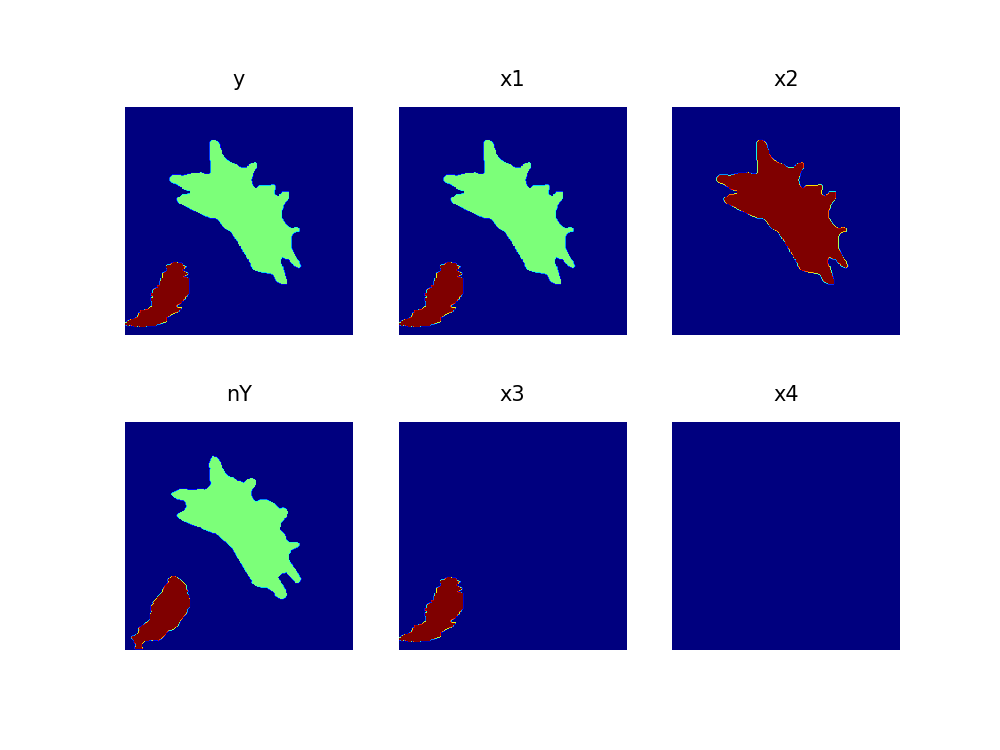

In [62]:



plt.rcParams['figure.dpi'] = 200    
plt.figure(num=2, figsize=(4, 3))
plt.subplot(2,3,1)
plt.axis('off')
plt.title('y', fontsize=6)
plt.imshow(y, cmap='jet')
plt.subplot(2,3,2)
plt.axis('off')
plt.title('x1', fontsize=6)
plt.imshow(x1, cmap='jet')
plt.subplot(2,3,3)
plt.axis('off')
plt.title('x2', fontsize=6)
plt.imshow(x2, cmap='jet')
plt.subplot(2,3,4)
plt.axis('off')
plt.title('nY', fontsize=6)
plt.imshow(new_spx[0,0], cmap='jet')
plt.subplot(2,3,5)
plt.axis('off')
plt.title('x3', fontsize=6)
plt.imshow(x3, cmap='jet')
plt.subplot(2,3,6)
plt.axis('off')
plt.title('x4', fontsize=6)
plt.imshow(x4, cmap='jet')
print()